In [1]:
import pybullet as p
import numpy as np
import sys
import os
import json
import open3d as o3d
import matplotlib.pyplot as plt
import time
from PIL import Image

sys.path.append("../")
from env.ycb_scene import SimulatedYCBEnv
from utils.grasp_checker import ValidGraspChecker
from utils.utils import *
from utils.planner import GraspPlanner
import utils.tcp_utils as tcp_utils

parent_directory = os.path.dirname(os.getcwd()) 
print(parent_directory)

pybullet build time: Nov 28 2023 23:51:11


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
/home/user/henry_pybullet_ws/src/pybullet_ros


In [2]:
from utils.planner import GraspPlanner
planner = GraspPlanner()

def expert_plan(goal_pose, world=False, visual=False):
    if world:
        pos, orn = env._get_ef_pose()
        ef_pose_list = [*pos, *orn]
    else:
        ef_pose_list = [0, 0, 0, 0, 0, 0, 1]
    goal_pos = [*goal_pose[:3], *ros_quat(goal_pose[3:])]

    solver = planner.plan(ef_pose_list, goal_pos, path_length=30)
    if visual:
        path_visulization(solver)
    path = solver.getSolutionPath().getStates()
    planer_path = []
    for i in range(len(path)):
        waypoint = path[i]
        rot = waypoint.rotation()
        action = [waypoint.getX(), waypoint.getY(), waypoint.getZ(), rot.w, rot.x, rot.y, rot.z]
        planer_path.append(action)

    return planer_path

def path_visulization(ss):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    x = []
    y = []
    z = []
    for i in range(len(ss.getSolutionPath().getStates())):
        state = ss.getSolutionPath().getStates()[i]
        x.append(state.getX())
        y.append(state.getY())
        z.append(state.getZ())
    ax.plot(x, y, z, color='gray', label='Curve')

    ax.scatter(x, y, z, c=z, cmap='jet', label='Points')
    plt.show()
    
def execute_motion_plan(env, plan, execute=False, gripper_set="close", repeat=100):
    """
    Executes a series of movements in a robot environment based on the provided plan.

    Parameters:
    - env: The current robot environment, providing inverse kinematics solving and stepping capabilities.
    - plan: A plan containing target positions, each position is a list with coordinates and orientation.
    - execute: A boolean indicating whether to execute the actions. If False, only resets the robot's joint positions without stepping through the environment.
    """

    '''
    plan中的每一個step都會做碰撞檢查, 如果有碰撞就會停止並回傳flase
    '''
    for i in range(len(plan)):
        # Set target position using world frame based coordinates
        next_pos = plan[i]
        jointPoses = env._panda.solveInverseKinematics(next_pos[:3], ros_quat(next_pos[3:]))
        if gripper_set == "close":
            jointPoses[6] = 0.85
        else:
            jointPoses[6] = 0.0
        jointPoses = jointPoses[:7].copy()  # Consider only the first 7 joint positions
                
        if execute:
            # Execute the action and obtain the observation
            obs = env.step(jointPoses, config=True, repeat=repeat)[0]
            # print("JointPoses = ", jointPoses)
        else:
            # Only reset the robot's joint positions
            env._panda.reset(joints=jointPoses)
            # 在path length中每一步都檢查是否會發生碰撞
            if(env._panda.check_for_collisions() == True):
                print("Collision detected in the path")
                return False
    return True

In [3]:
%%capture
'''
get data file name in json file and load mesh in pybullet
then reset robot and object position
'''

file = os.path.join(parent_directory, "object_index", 'contact_plane_object.json')   # 此json檔可以自己改
with open(file) as f: file_dir = json.load(f)
file_dir = file_dir['test_dataset']     #只取json檔中的"test"
file_dir = [f[:-5] for f in file_dir]
test_file_dir = list(set(file_dir))

env = SimulatedYCBEnv()
env._load_index_objs(test_file_dir)      #597

#ycb scene 中的 init 可以定義target_fixed, true代表target object不會自由落下 (第一次呼叫cabinet設定即可)
state = env.cabinet(save=False, enforce_face_target=True)  

startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1080 Ti/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 535.171.04
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 535.171.04
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce GTX 1080 Ti/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
numActiveThreads = 0
stopping threads
destroy semaphore
Thread with taskId 0 exiting
Thread TERMINATED
semaphore destroyed
destroy main semaphore
main semaphore destroye

In [4]:
'''
single release: (只在num_object = 1有用) true為以自己設定的角度放在桌上; (多object也可用)false就是pack放在桌上
if_stack: false代表旁邊有東西會擋住掉落下來的物體

_randomly_place_objects_pack
single_release/if_stack = t/t: 丟物體在桌上 沒遮擋
single_release/if_stack = f/t: pack物體在桌上 沒遮擋
single_release/if_stack = f/f: 丟物體在桌上 有遮擋
single_release/if_stack = t/f: 丟物體在桌上 有遮擋

'''
# stage2 是最上面的貨價
placing_stage = 2
num_object = 1
single_release =True
if_stack = True
draw_coordinate = False

### check for target on the table

In [5]:
target_on_table = 0
first_time = True
while(target_on_table < num_object):
    state = env.cabinet(save=False, reset_free=True, num_object=num_object, if_stack=if_stack, single_release=single_release)
    if(first_time):
        first_time = False
        placed_obj = {}
        placed_idx = np.where(np.array(env.placed_objects))[0]
        placed_name = np.array(env.obj_indexes)[np.where(np.array(env.placed_objects))]
        for i in range(num_object):
            placed_obj[placed_idx[i]] = placed_name[i]
        print(placed_obj)
    target_on_table = 0
    for i, index in enumerate(placed_obj.keys()):
        placed_name = placed_obj[index]
        env.target_idx = index
        target_pose_world = env._get_ef_pose(mat=True)@ env._get_target_relative_pose(option = 'ef')
        # get the target pose z height
        target_z_height = target_pose_world[2, 3]
        if target_z_height > -0.7:
            target_on_table += 1

single_release： True
x_rot:  0.04606298986193291
y_rot:  2.9684212539969295
z_rot:  -0.388727574172576
>>>> target name: 005_tomato_soup_can_1.0
{3: '005_tomato_soup_can_1.0'}


# Start multiview

In [6]:
### 將open3d下的點雲轉到world座標
world_frame_pose = np.array([[ 1.,    0.,    0.,   -0.05],
                            [ 0.,    1.,    0.,    0.  ],
                            [ 0.,    0.,    1.,   -0.65],
                            [ 0.,    0.,    0.,    1.  ]])

init_ef_mat = np.array([[-1.98785608e-01,  7.23231525e-01,  6.61377686e-01,  1.06898375e-01],
                        [9.80042993e-01,  1.46612626e-01,  1.34240345e-01, -9.29623842e-02],
                        [1.20530092e-04,  6.74863616e-01, -7.37942468e-01, -0.3],
                        [0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

left_view_ef_mat = np.array([[ 0.98757027,  0.02243495,  0.15556875,  0.45691898],
                            [ 0.14573556, -0.501431,   -0.85283533,  0.36891946],
                            [ 0.05887368,  0.86490672, -0.49846791, -0.3],
                            [ 0.,          0.,          0.,          1.]])

right_view_ef_mat = np.array([[ 0.98691477, -0.16087768,  0.010845,    0.46446365],
                            [-0.10023915, -0.55945926,  0.82277424, -0.28816143],
                            [-0.12629867, -0.81309514, -0.56826485, -0.3],
                            [ 0.,          0.,          0.,          1.]])

intrinsic_matrix = np.array([[320, 0, 320],
                            [0, 320, 320],
                            [0, 0, 1]])

cam_offset = np.eye(4)
# 先轉到pybullet座標後再往上移動0.13變相機座標
cam_offset[:3, 3] = (np.array([0., 0.1186, -0.0191344123493]))
# open3d 和 pybullet中的coordinate要對z旋轉180度才會一樣
cam_offset[:3, :3] = np.array([[-1, 0, 0],
                                [0, -1, 0],
                                [0, 0, 1]])

### 轉換關係
origin_camera2world = cam_offset@ np.linalg.inv(init_ef_mat)@ world_frame_pose
left_camera2world = cam_offset@ np.linalg.inv(left_view_ef_mat)@ world_frame_pose
right_camera2world = cam_offset@ np.linalg.inv(right_view_ef_mat)@ world_frame_pose

Debug:   RRTstar: Planner range detected to be 7.242362
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 310
Info:    RRTstar: Found an initial solution with a cost of 0.30 in 17 iterations (18 vertices in the graph)
Interpolate Path length to 30Info:    RRTstar: Created 1016 new states. Checked 516636 rewire options. 1 goal states in tree. Final solution cost 0.296

translation_diff =  3.0786970450373015e-05
rotation_diff =  0.0
origin checker: True
{3: '005_tomato_soup_can_1.0'}
3 005_tomato_soup_can_1.0


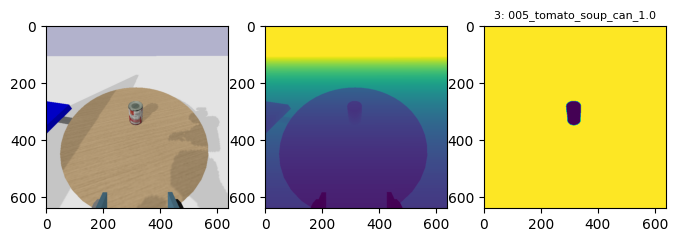

Debug:   RRTstar: Planner range detected to be 7.242362
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 310
Info:    RRTstar: Found an initial solution with a cost of 1.46 in 20 iterations (21 vertices in the graph)
Interpolate Path length to 30Info:    RRTstar: Created 1058 new states. Checked 560211 rewire options. 1 goal states in tree. Final solution cost 1.463

translation_diff =  1.2946390999179562e-08
rotation_diff =  0.0
left checker: True
{3: '005_tomato_soup_can_1.0'}
3 005_tomato_soup_can_1.0


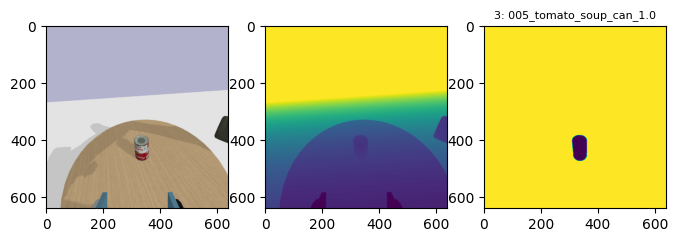

Debug:   RRTstar: Planner range detected to be 7.242362
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 310
Info:    RRTstar: Found an initial solution with a cost of 1.63 in 17 iterations (18 vertices in the graph)
Interpolate Path length to 30Info:    RRTstar: Created 1060 new states. Checked 562330 rewire options. 1 goal states in tree. Final solution cost 1.628

translation_diff =  1.2403757090793842e-08
rotation_diff =  0.0
right checker: True
{3: '005_tomato_soup_can_1.0'}
3 005_tomato_soup_can_1.0


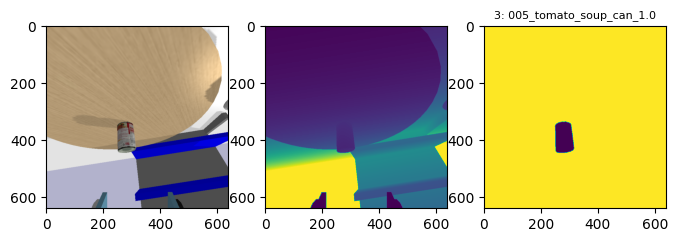

In [7]:
# state = env.cabinet(save=False, reset_free=True, num_object=num_object, 
# if_stack=if_stack, single_release=single_release, place_target_matrix=None)
#Henry set execute the robot arm or not
execute = False
env._panda.reset()

# 定義文件名和物體列表
objects = [placed_name[0]]
end_points = [init_ef_mat, left_view_ef_mat, right_view_ef_mat]
views_dict = {"origin": 0, "left": 1, "right": 2}
save_path = os.path.join(parent_directory, "multiview_data")

# 透過for迴圈處理不同的視角
for view_name, multiview_index in views_dict.items():
    END_POINT = end_points[multiview_index]  # 根據索引從結構中選擇對應的終點矩陣

    env._panda.reset()
    if draw_coordinate:
        env.draw_ef_coordinate(END_POINT, 5)
    plan = expert_plan(pack_pose(END_POINT), world=True, visual=False)
    execute_motion_plan(env, plan, execute=execute, gripper_set="open", repeat=200)
    checker = check_pose_difference(env._get_ef_pose(mat=True), END_POINT, tolerance=0.02)
    print(f"{view_name} checker: {checker}")
    save_observation_images(save_path, env, placed_obj, multiview_index)



In [8]:
env._panda.reset()
vis_pcd = False
# 創建 2 維列表來存儲圖像、深度和遮罩數據
rgb_list = []
depth_list = []
mask_list = []

for i, index in enumerate(placed_obj.keys()):
    placed_name = placed_obj[index]
    print(f"Processing {placed_name}...")
    # 清空列表來儲存下一個物體的數據rgbd
    obj_rgb = []
    obj_depth = []
    obj_mask = []

    for multiview_name, multiview_index in views_dict.items():
        # load特定物體的rgbd
        rgb, depth, mask = load_data(save_path, placed_name, multiview_index)
        obj_rgb.append(rgb)
        obj_depth.append(depth)
        obj_mask.append(mask)

    # 將特定物體的rgbd存入列表
    rgb_list.append(obj_rgb)
    depth_list.append(obj_depth)
    mask_list.append(obj_mask)

print(len(rgb_list), len(depth_list), len(mask_list))

# check the target object 誰距離init camera最近就選誰
min_depth = np.inf
closest_target_index = None

# 遍歷每個目標物體
for i, index in enumerate(placed_obj.keys()):
    # camera_transform = np.eye(4)因為用init camera的座標系去比較
    target_full, target_segments = create_point_cloud_and_camera(rgb_list[i][0], depth_list[i][0], mask_list[i][0], K = intrinsic_matrix)  
    origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=[0, 0, 0])
    # o3d.visualization.draw_geometries([target_segments, origin])
    target_segments = np.array(target_segments.points)
    # 使用目標物體對應的深度資訊中的最小值來計算目標深度
    target_depth = np.min(target_segments[:, 2])
    print(f"target_closet_depth: {target_depth}")
    
    # 如果這個目標物體比之前記錄的更接近相機，更新最小深度和索引
    if target_depth < min_depth:
        min_depth = target_depth
        # target_object 和 closest_target_index 不同
        closest_target_index = index
        target_object = i

print("最接近相機的目標物體索引是：", closest_target_index)
# tcp_client.
target_placed_name = placed_obj[closest_target_index]
tcp_utils.send_target_name('127.0.0.1', 11111, target_placed_name)
time.sleep(3) #等待placing mode 的server開啟才可以傳下面的東西

# Define intrinsic_matrix, placed_name, origin_camera2world, and other necessary variables.
for multiview_index in range(3):
    rgb, depth, mask = rgb_list[target_object][multiview_index], depth_list[target_object][multiview_index], mask_list[target_object][multiview_index]
    
    if multiview_index == 0:
        camera_transform = np.linalg.inv(origin_camera2world)
        color = None
        pc_full_pcd_0, pc_segments_pcd_0 = create_point_cloud_and_camera(rgb, depth, mask, intrinsic_matrix, camera_transform, color)
    elif multiview_index == 1:
        camera_transform = np.linalg.inv(left_camera2world)
        color = None
        pc_full_pcd_1, pc_segments_pcd_1 = create_point_cloud_and_camera(rgb, depth, mask, intrinsic_matrix, camera_transform, color)
    else:
        camera_transform = np.linalg.inv(right_camera2world)
        color = None
        pc_full_pcd_2, pc_segments_pcd_2 = create_point_cloud_and_camera(rgb, depth, mask, intrinsic_matrix, camera_transform, color)
    

robot_base = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.2, origin=[0, 0, 0])
camera0 = getCamera(np.linalg.inv(origin_camera2world), length=0.1, color=[1, 0, 0])
camera1 = getCamera(np.linalg.inv(left_camera2world), length=0.1, color=[0, 1, 0])
camera2 = getCamera(np.linalg.inv(right_camera2world), length=0.1, color=[0, 0, 1])

camera = [*camera0, *camera1, *camera2]

if vis_pcd:
    o3d.visualization.draw_geometries_with_animation_callback([*camera, robot_base, pc_segments_pcd_0, pc_segments_pcd_1, pc_segments_pcd_2], rotate_view)
    o3d.visualization.draw_geometries_with_animation_callback([*camera, robot_base, pc_full_pcd_0, pc_full_pcd_1, pc_full_pcd_2], rotate_view)

Processing 005_tomato_soup_can_1.0...
1 1 1
target_closet_depth: 0.38359999656677246
最接近相機的目標物體索引是： 3
已向服務端發送：005_tomato_soup_can_1.0


In [9]:
pc_segments_combine_pcd = get_combine_pcd(pc_segments_pcd_0, pc_segments_pcd_1, pc_segments_pcd_2)
pc_full_combine_pcd = get_combine_pcd(pc_full_pcd_0, pc_full_pcd_1, pc_full_pcd_2)
pc_segments_combine_pcd.transform(origin_camera2world)
pc_full_combine_pcd.transform(origin_camera2world)

# save the combine point cloud as npy
pc_segments_combine = np.asarray(pc_segments_combine_pcd.points)
pc_full_combine = np.asarray(pc_full_combine_pcd.points)

np.save(os.path.join(parent_directory, 'multiview_data/pc_segments_combine.npy'), pc_segments_combine)
np.save(os.path.join(parent_directory, 'multiview_data/pc_full_combine.npy'), pc_full_combine)
# save the pc_full_combine_pcd.colors to npy
pc_full_combine_colors = np.asarray(pc_full_combine_pcd.colors)
np.save(os.path.join(parent_directory, 'multiview_data/pc_full_combine_colors.npy'), pc_full_combine_colors)

In [10]:
def augment_depth_realsense(depth, depth_adjustment=0, coefficient_scale=1):
    # augment depth according to the empirical realsense paper
    # https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8768489&tag=1

    # print("ln250 augment depths")
    # print(np.max(depth))
    # print(np.min(depth))
    sigma = .001063*coefficient_scale + coefficient_scale*.0007278*(depth-depth_adjustment) \
            + coefficient_scale*.003949*(depth-depth_adjustment)**2
    new_depth = np.random.normal(loc=depth, scale=sigma)

    return new_depth
# apply realsense noise
# use augment_depth_realsense to augment the pc_combine_np
pc_full_combine_noise = augment_depth_realsense(pc_full_combine, coefficient_scale=1)
print(pc_full_combine.shape)
print(pc_full_combine_noise.shape)

pc_segments_combine_noise = augment_depth_realsense(pc_segments_combine, coefficient_scale=1)
print(pc_segments_combine_noise.shape)

# save the augmented point cloud as npy
np.save('../multiview_data/pc_full_combine_noise.npy', pc_full_combine_noise)
np.save('../multiview_data/pc_segments_combine_noise.npy', pc_segments_combine_noise)
# use open3d to visualize the augmented point cloud
pc_full_combine_noise_pcd = o3d.geometry.PointCloud()
pc_full_combine_noise_pcd.points = o3d.utility.Vector3dVector(pc_full_combine_noise)
pc_full_combine_noise_pcd.colors = o3d.utility.Vector3dVector(pc_full_combine_pcd.colors)
pc_full_combine_noise_pcd.transform(np.linalg.inv(origin_camera2world))
if vis_pcd:
    o3d.visualization.draw_geometries([pc_full_combine_noise_pcd, robot_base, *camera])

(514323, 3)
(514323, 3)
(14011, 3)


## use contact graspnet (ros service client)

In [11]:
import rospy
from pybullet_ros.srv import GraspGroup, GraspGroupRequest
from sensor_msgs.point_cloud2 import create_cloud_xyz32

contact_client = rospy.ServiceProxy('contact_graspnet/get_grasp_result', GraspGroup)
rospy.wait_for_service('contact_graspnet/get_grasp_result')

# Create a service request(depth image part)
contact_request = GraspGroupRequest()
header = rospy.Header()
header.stamp = rospy.Time.now()
header.frame_id = 'base_link'  # Replace with your desired frame ID
contact_request.pc_full = create_cloud_xyz32(header, pc_full_combine)
contact_request.pc_target = create_cloud_xyz32(header, pc_segments_combine)
contact_request.mode = 1
grasp_poses = contact_client(contact_request).grasp_poses
print(grasp_poses)

ModuleNotFoundError: No module named 'rospy'

: 

In [ ]:
# execute python3 contact_graspnet/inference_multiview.py --filter_grasps --local_regions
print(os.getcwd())
os.chdir("..")  # 移動到上一級目錄
print(os.getcwd())
!python3 contact_graspnet/inference_multiview.py --filter_grasps --local_regions
# 移動到下一級目錄
os.chdir("example_henry")  # 移動到上一級目錄

/home/user/contact_graspnet_ws/src/contact_graspnet_ros/example_henry
/home/user/contact_graspnet_ws/src/contact_graspnet_ros
2024-04-19 13:46:30.842431: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2024-04-19 13:46:31.584654: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-04-19 13:46:31.585142: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-04-19 13:46:31.607222: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-19 13:46:31.607306: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 

# GET 6D POSE
obb get 6d pose 
or 
use ground truth

In [ ]:
from utils.my_utils import PointCloudPoseEstimator
import numpy as np
gt = True
vis = False

pc_segments_path = '../multiview_data/pc_segments_combine.npy'
pc_segments_noise_path = '../multiview_data/pc_segments_combine_noise.npy'
poseEstimate = PointCloudPoseEstimator(pc_segments_path, pc_segments_noise_path, init_ef_mat, cam_offset)
result_z_rotation_angle = 0
env.target_idx = closest_target_index
if gt == True:
        # ground truth
        target_pose_world = env._get_ef_pose(mat=True)@ env._get_target_relative_pose(option = 'ef')
        # rotate the target pose if the x of the target pose inner product with the x of the ef pose is negative
        print(placed_name)
        if "025_mug_1.0" in placed_name or '021_bleach_cleanser_1.0' in placed_name:
                # rotate 90 degree around z axis of the target pose
                target_pose_world[:3, :3] = target_pose_world[:3, :3]@ np.array([[0, -1, 0],
                                                                                [1, 0, 0],
                                                                                [0, 0, 1]])
                print("rotate 90 degree around z axis of the target pose")
                result_z_rotation_angle += 90
        if np.dot(target_pose_world[:3, 0], env._get_ef_pose(mat=True)[:3, 2]) > 0:
                # rotate 180 degree around z axis of the target pose
                target_pose_world[:3, :3] = target_pose_world[:3, :3]@ np.array([[-1, 0, 0],
                                                                                [0, -1, 0],
                                                                                [0, 0, 1]])
                print("rotate 180 degree around z axis of the target pose")
                result_z_rotation_angle += 180
        print("result_z_rotation_angle", result_z_rotation_angle)


else:
        target_pose_world = poseEstimate.get_6d_pose()

print(target_pose_world)
if vis:
        # can see the target pose, cabinet pose and ef pose in pybullet
        env.draw_ef_coordinate(env._get_ef_pose(mat=True), 5)
        env.draw_ef_coordinate(env._get_target_urdf_pose(option = 'cabinet_world', mat = True), 5)
        env.draw_ef_coordinate(target_pose_world, 5)


['/home/user/contact_graspnet_ws/src/contact_graspnet_ros/example_henry', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/user/.local/lib/python3.8/site-packages', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '../']
005_tomato_soup_can_1.0
rotate 180 degree around z axis of the target pose
result_z_rotation_angle 180
[[ 0.50906861  0.20516006  0.83591779  0.52574225]
 [-0.78443087 -0.28916305  0.54868295 -0.02939598]
 [ 0.35428435 -0.93503692  0.01373006 -0.56927124]
 [ 0.          0.          0.          1.        ]]


In [ ]:
# env.draw_ef_coordinate(env._get_ef_pose(mat=True)@ env._get_target_relative_pose(option = 'ef'), 5)

# 轉換所有的grasp pose
- 找到每個grasp pose和target object轉換矩陣, 並將其轉換到place pose的位置
- extract會產生碰撞的grasp pose

In [ ]:
pred_grasps_cam = np.load(os.path.join(parent_directory, 'results/pred_grasps_cam.npy'), allow_pickle=True)
scores = np.load(os.path.join(parent_directory, 'results/scores.npy'), allow_pickle=True)
print(pred_grasps_cam.shape)
new_pred_grasps_cam = init_ef_mat@ np.linalg.inv(cam_offset)@ pred_grasps_cam
print("Number of init grasp: ", new_pred_grasps_cam.shape[0])

(65, 4, 4)
Number of init grasp:  65


### 得到place pose

In [ ]:
# 將所有pose轉換到place pose
print('target_pose_world = \n{}'.format(target_pose_world))
cabinet_pose_world = env._get_target_urdf_pose(option = 'cabinet_world', mat = True)
cabinet_pose_world_stage1 = cabinet_pose_world.copy()
cabinet_pose_world_stage2 = cabinet_pose_world.copy()

# stage1 
cabinet_pose_world_stage1[0, 3] += 0.
cabinet_pose_world_stage1[1, 3] += -0.3
cabinet_pose_world_stage1[2, 3] += 0.2

# stage2
cabinet_pose_world_stage2[0, 3] += 0.
cabinet_pose_world_stage2[1, 3] += -0.3
cabinet_pose_world_stage2[2, 3] += 0.5

# chose the cabinet pose
if placing_stage == 1:
    cabinet_pose_world = cabinet_pose_world_stage1
elif placing_stage == 2:
    cabinet_pose_world = cabinet_pose_world_stage2
env.draw_ef_coordinate(cabinet_pose_world, 5)

target_pose_world = 
[[ 0.50906861  0.20516006  0.83591779  0.52574225]
 [-0.78443087 -0.28916305  0.54868295 -0.02939598]
 [ 0.35428435 -0.93503692  0.01373006 -0.56927124]
 [ 0.          0.          0.          1.        ]]


### 微調place pose

In [ ]:
#上方OBB得到值
# z_translation = poseEstimate.get_normal_translation()-0.015
z_translation = poseEstimate.get_normal_translation()
y_translation = -0.
x_translation = 0.
print('z_translation = {}'.format(z_translation))
place_pose_world = cabinet_pose_world.copy()
place_pose_world[:3, 3] += np.array([x_translation, y_translation, z_translation])
env.draw_ef_coordinate(place_pose_world, 5)
new_pred_grasps_cam_place = np.zeros_like(new_pred_grasps_cam)

for i in range(new_pred_grasps_cam.shape[0]):
    relative_grasp_transform = np.linalg.inv(target_pose_world)@ new_pred_grasps_cam[i]
    new_pred_grasps_cam_place[i] = place_pose_world@ relative_grasp_transform
    # every grasp pose traslate z -0.03
    new_pred_grasps_cam_place[i][2, 2] -= 0.03

print("Number of place grasp: ", new_pred_grasps_cam_place.shape)

# tcp傳送
np.save('../results/new_pred_grasps_cam_place.npy', new_pred_grasps_cam_place)
time.sleep(3) #等待placing mode 的server開啟才可以傳下面的東西
tcp_utils.send_checker('127.0.0.1', 22222) 
time.sleep(3) #等待placing mode 的server開啟才可以傳下面的東西

x = 0.11400542948129694(m)
y = 0.07752736516113745(m)
z = 0.08380045473216566(m)
z_translation = 0.05700271474064847
Number of place grasp:  (65, 4, 4)
已發送checker到服務端。


### 擺放target object到place pose

In [ ]:
# tcp server
final_place_target_matrix = place_pose_world@ get_rotation_matrix_z_4x4(-result_z_rotation_angle/90)
tcp_utils.send_matrix('127.0.0.1', 33333, final_place_target_matrix)
time.sleep(1)
tcp_utils.send_matrix('127.0.0.1', 55557, place_pose_world)
time.sleep(1)
tcp_utils.send_matrix('127.0.0.1', 56565, target_pose_world)

# 測試夾取及擺放是否能成功
的到world ef的place pose和grasp pose

In [ ]:
def move_gripper_smoothly(env, p, start_opening, target_opening, steps=8000):
    """
    逐步移動夾爪從一個開合程度到另一個開合程度。

    參數:
        env: 包含夾爪控制函數的環境物件。
        p: 包含步進模擬函數的物理模擬物件。
        start_opening (float): 初始夾爪開合程度，範圍在0到0.085之間。
        target_opening (float): 目標夾爪開合程度，範圍在0到0.085之間。
        steps (int): 從初始開合程度到目標開合程度的步數。
        # 使用範例
        # 假設您已經有了env物件和p物件，以及想要設定的開始和目標開合程度
        move_gripper_smoothly(env, p, 0.085, 0.0)  # close
        move_gripper_smoothly(env, p, 0.0, 0.085)  # open
    """
    x = start_opening
    delta = (target_opening - start_opening) / steps  # 計算每一步的變化量
def execute_motion_and_check_pose(env, END_POINT, tolerance=0.02, gripper_state="open", repeat=150, visual_time=None):
    """
    執行動作計畫並檢查最後位姿是否正確。不正確則停5秒
    """
    if draw_coordinate:
        env.draw_ef_coordinate(END_POINT, visual_time)
    plan = expert_plan(pack_pose(END_POINT), world=True, visual=False)
    _ = execute_motion_plan(env, plan, execute=execute, gripper_set=gripper_state, repeat=repeat)
    checker = check_pose_difference(env._get_ef_pose(mat=True), END_POINT, tolerance)
    if not checker:
        print("位姿不正確，請檢查位姿")
        time.sleep(5)
    print("=====================================================")

def adjust_pose_with_bias(pose, bias, option="ef"):
    if option == "ef":
        return pose@transZ(bias)
    elif option == "world":
        return transZ(bias)@pose

    for i in range(steps):
        env._panda.move_gripper(x)
        x += delta  # 更新夾爪的開合程度
        p.stepSimulation()  # 進行一次物理模擬步進

## tcp傳入final_place_grasp_pose

In [ ]:
# tcp client
final_place_grasp_pose = tcp_utils.start_server('127.0.0.1', 44444)
print("final_place_grasp_pose received")

# 將此final place pose 轉移回grasp pose
relative_grasp_transform = np.linalg.inv(place_pose_world)@ final_place_grasp_pose
final_grasp_pose = target_pose_world@ relative_grasp_transform
print("final_grasp_pose = \n", final_grasp_pose)

伺服器啟動，等待連接並接收...
來自 ('127.0.0.1', 36698) 的連接已建立
接收到的矩陣：
[[-0.38018123  0.30048049  0.87474211  0.00740156]
 [ 0.91406082 -0.02238357  0.40495894  0.45617846]
 [ 0.14126211  0.95352524 -0.29614762 -0.19005727]
 [ 0.          0.          0.          1.        ]]
final_place_grasp_pose received
final_grasp_pose = 
 [[-0.42523416  0.87011008 -0.27424481  0.57330642]
 [ 0.90446     0.41873682 -0.09777196 -0.00794761]
 [ 0.03358558 -0.25993825 -0.9654529  -0.46643612]
 [ 0.          0.          0.          1.        ]]


## 確認可以放置後, 開始夾取

In [ ]:
# #Henry set execute the robot arm or not
execute = True
draw_coordinate = False
env._panda.reset()

In [ ]:
def execute_motion_and_check_pose(env, END_POINT, tolerance=0.02, gripper_state="open", repeat=150, visual_time=None):
    """
    執行動作計畫並檢查最後位姿是否正確。不正確則停5秒
    """
    if draw_coordinate:
        env.draw_ef_coordinate(END_POINT, visual_time)
    plan = expert_plan(pack_pose(END_POINT), world=True, visual=False)
    _ = execute_motion_plan(env, plan, execute=execute, gripper_set=gripper_state, repeat=repeat)
    checker = check_pose_difference(env._get_ef_pose(mat=True), END_POINT, tolerance)
    if not checker:
        print("位姿不正確，請檢查位姿")
        time.sleep(5)
    print("=====================================================")

def adjust_pose_with_bias(pose, bias, option="ef"):
    if option == "ef":
        return pose@transZ(bias)
    elif option == "world":
        return transZ(bias)@pose


In [ ]:
final_grasp_pose_z_bias = adjust_pose_with_bias(final_grasp_pose, -0.05, option="ef")
if placing_stage == 1:
    mid_retract_pose = transZ(-0.)@ transX(0.3)@ transY(0.2)@ np.eye(4)@ rotZ(np.pi/4*3)@ rotX(np.pi/4*3)
elif placing_stage == 2:
    mid_retract_pose = transZ(-0.)@ transX(0.3)@ transY(0.2)@ np.eye(4)@ rotZ(np.pi/4*3)@ rotX(np.pi/4*3)
final_place_pose_z_bias_top = adjust_pose_with_bias(final_place_grasp_pose, 0.15, option="world")
final_place_pose_z_bias_placing = adjust_pose_with_bias(final_place_grasp_pose, 0.02, option="world")
final_place_pose_z_bias_release = adjust_pose_with_bias(final_place_grasp_pose, -0.1, option="ef")

In [ ]:
execute_motion_and_check_pose(env, final_grasp_pose_z_bias, gripper_state="open")
time.sleep(1)
for i in range(10):
    _ = env.step([0, 0, 0.05/10, 0, 0, 0], repeat=100)
reward = env.retract()
print(f"reward: {reward}")
execute_motion_and_check_pose(env, mid_retract_pose, tolerance = 0.1, gripper_state="close")
execute_motion_and_check_pose(env, final_place_pose_z_bias_top, gripper_state="close")
execute_motion_and_check_pose(env, final_place_pose_z_bias_placing, gripper_state="close", repeat=100)
move_gripper_smoothly(env, p, 0.0, 0.085)  # open
execute_motion_and_check_pose(env, final_place_pose_z_bias_release, gripper_state="open", repeat=100)

Debug:   RRTstar: Planner range detected to be 7.242362
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 310
Info:    RRTstar: Found an initial solution with a cost of 1.03 in 36 iterations (37 vertices in the graph)


Interpolate Path length to 30Info:    RRTstar: Created 682 new states. Checked 232903 rewire options. 1 goal states in tree. Final solution cost 1.031

translation_diff =  0.03190396124345163
rotation_diff =  0.0
位姿不正確，請檢查位姿
not lift！
reward: 0
Debug:   RRTstar: Planner range detected to be 7.242362
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 310
Info:    RRTstar: Found an initial solution with a cost of 0.68 in 15 iterations (16 vertices in the graph)
Interpolate Path length to 30Info:    RRTstar: Created 937 new states. Checked 439453 rewire options. 1 goal states in tree. Final solution cost 0.678

translation_diff =  0.003550574047832506
rotation_diff =  0.006764598879464605
Debug:   RRTstar: Planner range detected to be 7.242362
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 310
Info:    RRTstar: Found an

resetjointArray...（一次抵達)
setJointMotorControl2... (step中使用)

In [ ]:
env.target_idx = closest_target_index
target_final = env._get_ef_pose(mat=True)@ env._get_target_relative_pose(option = 'ef')
# check the z axis of the target_final with the [0, 0, 1] vector
z_axis_target = target_final[:3, 2]
z_axis_target = z_axis_target/np.linalg.norm(z_axis_target)
cos_theta = np.dot(np.array([0, 0, 1]), z_axis_target)
if cos_theta < 0.9:
    print("The target is not vertical to the ground")
    raise ValueError("The target is not vertical to the ground")


The target is not vertical to the ground


ValueError: The target is not vertical to the ground

: 